## Circuit Noise Simulations

To benchmark our measurement protocol, it is essential to simulate noisy quantum circuits using tensor-network methods. Such simulations can be performed either via density-matrix techniques or by employing quantum trajectory methods. For further details on these simulation approaches, see [Daniel Jaschke et al., 2019, Quantum Sci. Technol. 4, 013001](https://iopscience.iop.org/article/10.1088/2058-9565/aae724).

In this notebook, we illustrate several basic routines for simulating noisy random circuits:

- **Noise Model:**  
  We implement a local depolarization channel as our noise model.

- **Simulation Methods:**  
  1. **Density Matrix MPO Simulation:**  
     This method uses Matrix Product Operators (MPOs) to simulate the full density matrix of the system. While this approach accurately captures mixed-state dynamics, it requires roughly double the memory since the Hilbert space is effectively squared.
  
  2. **Quantum Trajectory (Pure State Sampling) Simulation:**  
     Here, the evolution is simulated via pure states only (using techniques similar to quantum trajectories). This method is more memory efficient but requires averaging over many sampled trajectories to reproduce the mixed-state behavior.

These simulation methods provide complementary insights into the effects of noise on quantum circuits and help us benchmark the performance of randomized measurement protocols.

In [1]:
using RandomMeas

We first construct the (ideal, pure) random circuit wavefunction $\ket{\psi}$ with an overall circuit depth of $d = 2$ steps by successively applying layers of depth-2 random brickwork circuits.

In [2]:
# Number of qubits and number of evolution steps
N = 40
num_steps = 3

# Generate site indices for a chain of N qubits.
ξ = siteinds("Qubit", N)

# Define the initial state.
initial_state = ["Dn" for n in 1:N]

# Set a cutoff parameter for truncation in apply.
cutoff = 1e-8

# Create the initial MPS from the initial state.
ψ0 = MPS(ξ, initial_state)

# Initialize a vector to store the MPS at each evolution step.
ψ = MPS[]  # Vector of MPSs representing the state at each step
push!(ψ, ψ0)

# Initialize a vector to store the circuit layers (each a vector of ITensors representing gates).
circuit_layer = Vector{Vector{ITensor}}()

# Apply a random circuit layer at each step.
@showprogress dt=1 for d in 1:num_steps
    # For each step, generate a random circuit of depth 2.
    push!(circuit_layer, random_circuit(ξ, 2))
    
    # Apply the generated circuit layer to the current state, using the specified cutoff.
    new_state = apply(circuit_layer[d], ψ[d]; cutoff=cutoff)
    push!(ψ, new_state)
end

println("Pure states prepared through unitary evolution.")
println("Maximal bond dimension:", maxlinkdim(ψ[end]))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:11


Pure states prepared through unitary evolution.
Maximal bond dimension:54


In order to simulate the experimental state in the presence of noise, we incorporate a local depolarization channel that transforms the pure state into a mixed state \(\rho\). This is achieved by directly applying the depolarization channel to the MPO \(\rho\) produced by the ITensor function `apply`, thereby modeling the effect of local noise on the system.

In [ ]:
# Initialize the mixed-state density matrix from the initial pure state ψ0.
ρ = outer(ψ0', ψ0)

# Generate a vector of depolarization probabilities (one per qubit).
p = 0.05 * rand(N)

# Preallocate an array to store fidelity values for each evolution step.
Fidelity = zeros(Float64, num_steps)

# Evolve the state: for each circuit layer, apply the circuit and a depolarization channel.
@showprogress dt=1 for d in 1:num_steps
    # Update the density matrix ρ by applying the d-th circuit layer with dagger applied to the second argument.
    ρ = apply(circuit_layer[d], ρ, apply_dag=true; cutoff=cutoff)
    # Apply the local depolarization channel on ρ.
    ρ = apply_depo_channel(ρ, p)
    # Compute fidelity between the updated noisy state and the corresponding pure state.
    Fidelity[d] = real(inner(ψ[d+1]', ρ, ψ[d+1]))
end

println("Mixed states prepared through noisy evolution.")
println("Maximal bond dimension:", maxlinkdim(ρ))

Mixed states prepared through noisy evolution.
Maximal bond dimension:1844


Alternatively, one can sample quantum trajectories. In this approach, for each trajectory, random Pauli operators (\(X\), \(Y\), \(Z\)) are applied independently on each qubit. This method significantly reduces the memory footprint—since each trajectory is represented by a pure state rather than a full density matrix - in contrast, it requires averaging over many trajectories to obtain reliable results.

In [4]:
using StatsBase

# Number of trajectories for the simulation
ntraj = 1000

# Preallocate an array to store fidelity values for each trajectory and each step.
# 'steps' should be defined previously (e.g. steps = num_steps).
Fidelity_traj = zeros(Float64, ntraj, num_steps)

@showprogress dt=1 for traj in 1:ntraj
    # Start each trajectory from the initial pure state.
    ψ_traj = copy(ψ0)
    for d in 1:num_steps
        # Apply the d-th circuit layer to evolve the state.
        ψ_traj = apply(circuit_layer[d], ψ_traj; cutoff=cutoff)
        # Apply a random Pauli depolarization layer.
        depo_layer = random_Pauli_layer(ξ, p)
        ψ_traj = apply(depo_layer, ψ_traj; cutoff=cutoff)
        # Compute fidelity for this step (comparing evolved state with the pure state from ψ[d+1])
        Fidelity_traj[traj, d] = abs(inner(ψ_traj, ψ[d+1]))^2
    end
end

# Compute the mean fidelity over all trajectories (along the first dimension)
mean_fidelity = vec(mean(Fidelity_traj, dims=1))
# Compute the standard error of the mean (SEM) for the fidelity estimates.
sem_fidelity = vec(std(Fidelity_traj, dims=1) ./ sqrt(size(Fidelity_traj, 1)))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


3-element Vector{Float64}:
 0.014859466528953662
 0.01321781413840129
 0.010152099797954612

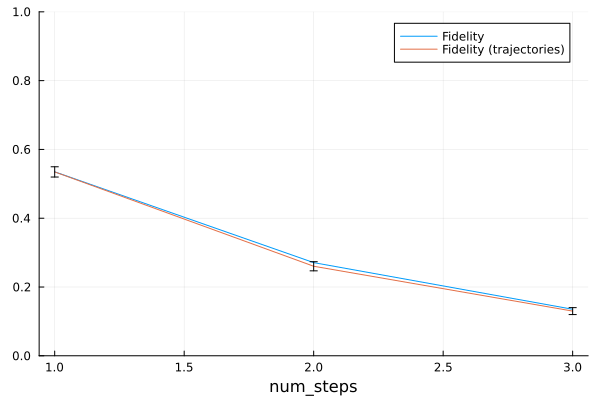

In [8]:
using Plots
plot(1:num_steps,Fidelity,label="Fidelity")
plot!(1:num_steps,mean_fidelity,yerr=sem_fidelity,label="Fidelity (trajectories)")
ylims!((0,1))
xlabel!("num_steps")